# Invasion Percolation

In [1]:
import sys
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt
try:
    import porespy as ps
except ModuleNotFoundError:
    !{sys.executable} -m pip install porespy
    import porespy as ps
from ipywidgets import interact, IntSlider
from openpnm.topotools import trim
%matplotlib inline

In [2]:
spacing=2.5e-5
net = op.network.Cubic([20, 20, 1], spacing=spacing)
geo = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)

In [3]:
net.labels()
net.num_throats('surface')
trim(network=net, throats=net.throats('surface'))
h = net.check_network_health()
trim(network=net, pores=h['trim_pores'])

In [4]:
im = ps.io.openpnm_to_im(net, max_dim=1000)


--------------------------------------------
| Generating voxel image from pore network |
--------------------------------------------


Generating throats: 100%|██████████████████████████████████████████████████████████| 684/684 [00:00<00:00, 5805.79it/s]


In [5]:
im.shape

(1000, 1000, 50)

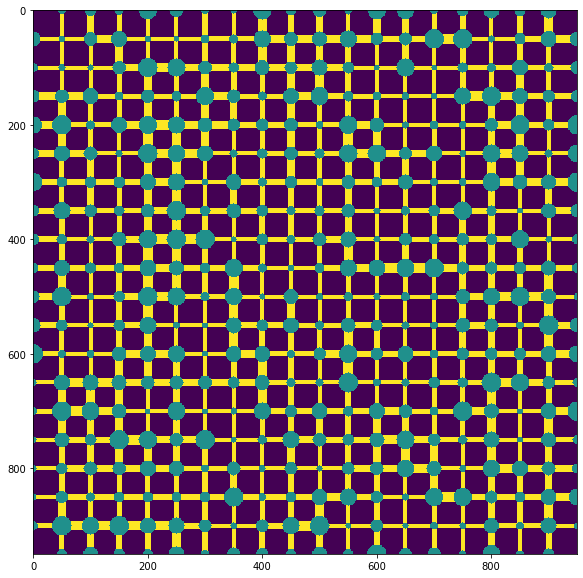

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(im[25:-25, 25:-25, 25].T)
crop = im[25:-25, 25:-25, :]

In [ ]:
snow_out = ps.networks.snow(crop > 0, voxel_size=4e-7)

____________________________________________________________
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1080
Peaks after trimming saddle points:  378
Peaks after trimming nearby peaks:  378


In [ ]:
snow_out.regions.shape

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
reg = snow_out.regions.astype(float) - 1
reg[reg == -1] = np.nan
region_slice = snow_out.regions[:, :, 28] - 1
mask = region_slice >= 0
plt.imshow(region_slice.T)

In [ ]:
wrk = op.Workspace()
wrk.clear()

In [ ]:
net = op.network.GenericNetwork()
net.update(snow_out)
geo = op.geometry.GenericGeometry(network=net, pores=net.Ps, throats=net.Ts)

In [ ]:
def update_image(data):
    data = data.astype(float)
    out_im = np.ones(region_slice.shape, dtype=float)*-1
    out_im[mask] = data[region_slice[mask]]
    out_im[~mask] = np.nan
    return out_im

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
out = update_image(net['pore.diameter'])
plt.imshow(out.T)

In [ ]:
water = op.phases.Water(network=net)
phys = op.physics.Standard(network=net, geometry=geo, phase=water)

In [ ]:
fig, ax = plt.subplots(figsize=[10, 10])
ax.hist(phys['throat.entry_pressure'], bins=10)

In [ ]:
alg_ip = op.algorithms.InvasionPercolation(network=net)
alg_ip.setup(phase=water)
alg_ip.set_inlets(pores=net.pores('left'))
alg_ip.run()
fig, ax = plt.subplots(figsize=(10, 10))
out = update_image(alg_ip['pore.invasion_sequence'])
plt.imshow(out.T)

In [ ]:
def plot_invasion(seq):
    data = alg_ip['pore.invasion_sequence'] < seq
    fig, ax = plt.subplots(figsize=(10, 10))
    out = update_image(data)
    plt.imshow(out.T)

In [ ]:
max_seq = alg_ip['pore.invasion_sequence'].max()
interact(plot_invasion, seq=IntSlider(min=0, max=max_seq, step=1, value=200))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
alg_ip.plot_intrusion_curve(fig)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
alg_op = op.algorithms.OrdinaryPercolation(network=net, phase=water)
alg_op.set_inlets(net.pores('left'))
alg_op.setup(pore_volume='pore.volume',
             throat_volume='throat.volume')
alg_op.run(points=1000)
alg_op.plot_intrusion_curve(fig)
alg_ip.plot_intrusion_curve(fig)
plt.show()

In [ ]:
alg_ip_t = op.algorithms.InvasionPercolation(network=net)
alg_ip_t.setup(phase=water)
alg_ip_t.set_inlets(pores=net.pores('left'))
alg_ip_t.run()
alg_ip_t.apply_trapping(outlets=net.pores(['boundary']))
fig, ax = plt.subplots(figsize=(10, 10))
out = update_image(alg_ip_t['pore.trapped'])
plt.imshow(out.T)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
alg_ip.plot_intrusion_curve(fig)
alg_ip_t.plot_intrusion_curve(fig)
plt.show()